In [1]:
import numpy as np 
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from itertools import product
from time import time
from tqdm import tqdm

## Part 1a

In [42]:
data = np.load('part1a.npz')
data.files

['N', 'Svc_0_pmf', 'Lc', 'Ic_0', 'gamma']

In [43]:
# Total population, N.
N = data['N']
# Everyone else, S0, is susceptible to infection initially.
S = data['Svc_0_pmf'] * data['N']
# Initial number of infected and recovered individuals, I0 and R0.
I = data['Ic_0']
R = 0
# Contact rate: beta, mean recovery rate: gamma (in 1/days).
gamma = data['gamma']
beta = np.linspace(0.1,0.3,16).reshape(4,4) # arbitrary non-decreasing beta values
L = data['Lc']

t = (0, 120)

In [55]:
def SIR(t, y, L, N, beta, gamma):
    '''Must solve 4 Ic in order to solve 1 Svc. Must 
    solve 4 Svc in order to solve 1 Ic. Must solve 4 Ic in order to solve
    1 R. Must solve 4 Ic to solve 1  L.'''
    S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = y

    dS00dt = -beta[0,0] * S00 * I0 / N
    dS10dt = -beta[1,0] * S10 * I0 / N
    dS20dt = -beta[2,0] * S20 * I0 / N
    dS30dt = -beta[3,0] * S30 * I0 / N
    
    dS01dt = -beta[0,1] * S01 * I0 / N
    dS11dt = -beta[1,1] * S11 * I0 / N
    dS21dt = -beta[2,1] * S21 * I0 / N
    dS31dt = -beta[3,1] * S31 * I0 / N
    
    dS02dt = -beta[0,2] * S02 * I0 / N
    dS12dt = -beta[1,2] * S12 * I0 / N
    dS22dt = -beta[2,2] * S22 * I0 / N
    dS32dt = -beta[3,2] * S32 * I0 / N

    dS03dt = -beta[0,3] * S03 * I0 / N
    dS13dt = -beta[1,3] * S13 * I0 / N
    dS23dt = -beta[2,3] * S23 * I0 / N
    dS33dt = -beta[3,3] * S33 * I0 / N
    
    dI1dt = -1 * np.sum([dS00dt,dS10dt,dS20dt,dS30dt]) - (gamma * I1)
    dI2dt = -1 * np.sum([dS01dt,dS11dt,dS21dt,dS31dt]) - (gamma * I2)
    dI3dt = -1 * np.sum([dS02dt,dS12dt,dS22dt,dS32dt]) - (gamma * I3)
    dI4dt = -1 * np.sum([dS03dt,dS13dt,dS23dt,dS33dt]) - (gamma * I4)
    dIdt = np.sum([dI1dt, dI2dt, dI3dt, dI4dt]) 
    
    dRdt = gamma * I0
       
    return dS00dt, dS01dt, dS02dt, dS03dt,\
    dS10dt,dS11dt,dS12dt,dS13dt, \
    dS20dt,dS21dt,dS22dt, dS23dt, \
    dS30dt,dS31dt,dS32dt,dS33dt, \
    dI1dt, dI2dt, dI3dt, dI4dt, \
    dIdt, dRdt

1) Using the model dynamics described in the previous section, and all the given and chosen parameters, simulate the behavior of the disease for 120 days for this single leaf node

In [46]:

# ax[0].set(xlabel = "t (Time in days)", ylabel = "Number",
#          title = "SIR Curve")
soln = solve_ivp(SIR, t, y0 = (S[0,0],S[0,1],S[0,2],S[0,3],
                               S[1,0],S[1,1],S[1,2],S[1,3],
                               S[2,0],S[2,1],S[2,2],S[2,3],
                               S[3,0],S[3,1],S[3,2],S[3,3],
                               I[0],I[1],I[2],I[3], I.sum(), R), 
                 dense_output = True, t_eval=np.arange(121),\
                 args = (L, N, beta, gamma) )

2) Plot $S_{v,c}$ and $I_{c}$ values over time. (You can plot all $S_{v,c}$ on the same plot. Same for $I_{c}$). Also plot the overall S, I, R and L values.

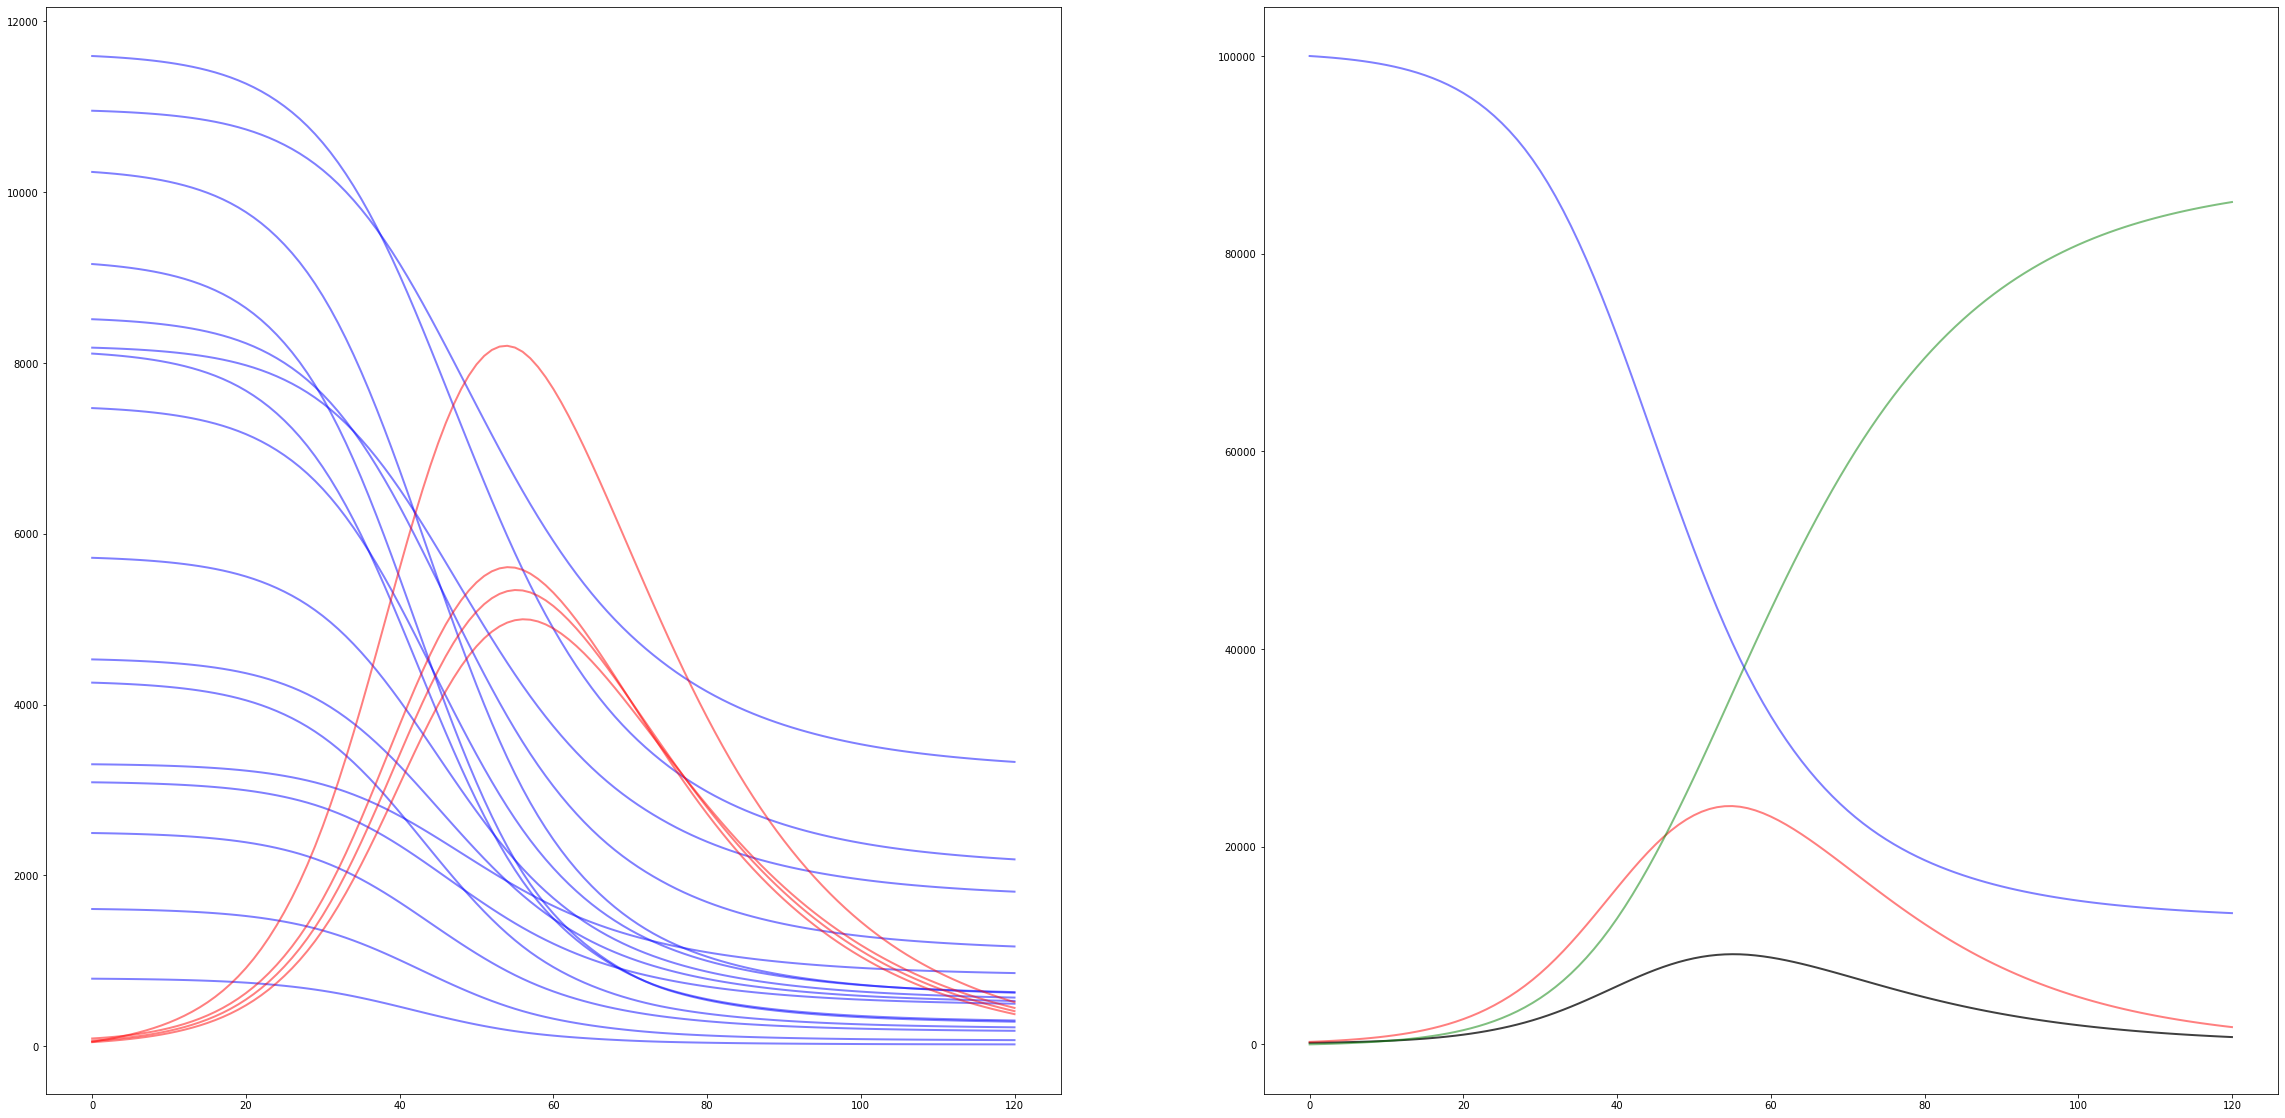

In [54]:
fig, ax = plt.subplots(1, 2, sharex = True, figsize = (40,20) )
S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = soln.y

all_S = np.array([S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33])
all_I = [I1,I2,I3,I4]
# Plot viral load density L
Lty = (I1 * L[0] + I2 * L[1] + I[3] * L[2] + I4 * L[3])
ax[1].plot(soln.t, Lty, 'black', alpha = 0.75, lw = 2, label = 'Viral Load Density')
# Plot Susceptible vc
for Svc in all_S:
    ax[0].plot(soln.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')

# Plot # Infected vc
for Ic in all_I:
    ax[0].plot(soln.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')

# Plot Overall S, I, R
ax[1].plot(soln.t, np.sum(all_S, axis = 0), 'b', alpha=0.5, lw=2, label='Susceptible')
ax[1].plot(soln.t, np.sum(all_I, axis = 0),'r', alpha=0.5, lw=2, label='Infected')
ax[1].plot(soln.t, R0, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

3) Do the shapes of S, I, R look similar to what you expected? Which of these plots is the “curve” people refer to when they say “flatten the curve”?

4) Do you observe that some Sv,c compartments converged to zero while others converged to a positive value? Why do you think that is?

5) Print the percentages of population that never got infected for all compartments (i.e. all values of v and c).


In [56]:
v = 0
c = 0
for Svc in all_S:
    print(f"S: v = {v}, c = {c}: {Svc[-1]/Svc[0]}")
    if c == 3:
        v +=1
        c = 0
    c += 1

S: v = 0, c = 0: 0.30385930986884385
S: v = 0, c = 1: 0.25925183318555345
S: v = 0, c = 2: 0.22116861930870635
S: v = 0, c = 3: 0.18864642323700023
S: v = 1, c = 1: 0.16086522528162292
S: v = 1, c = 2: 0.13712696724770584
S: v = 1, c = 3: 0.11683742143621478
S: v = 2, c = 1: 0.09949073472600328
S: v = 2, c = 2: 0.08465625641671017
S: v = 2, c = 3: 0.07196731535123997
S: v = 3, c = 1: 0.06111166046891348
S: v = 3, c = 2: 0.05182332054652795
S: v = 3, c = 3: 0.043875674474910344
S: v = 4, c = 1: 0.037075553858456
S: v = 4, c = 2: 0.03125822575595577
S: v = 4, c = 3: 0.02628312563766615


6) Multiply all the βv,c values by 1/4. What happened to the S, I, R plots? Did the “curve” flatten compared to the previous case? Print the percentages of population that never got infected with these βv,c values.

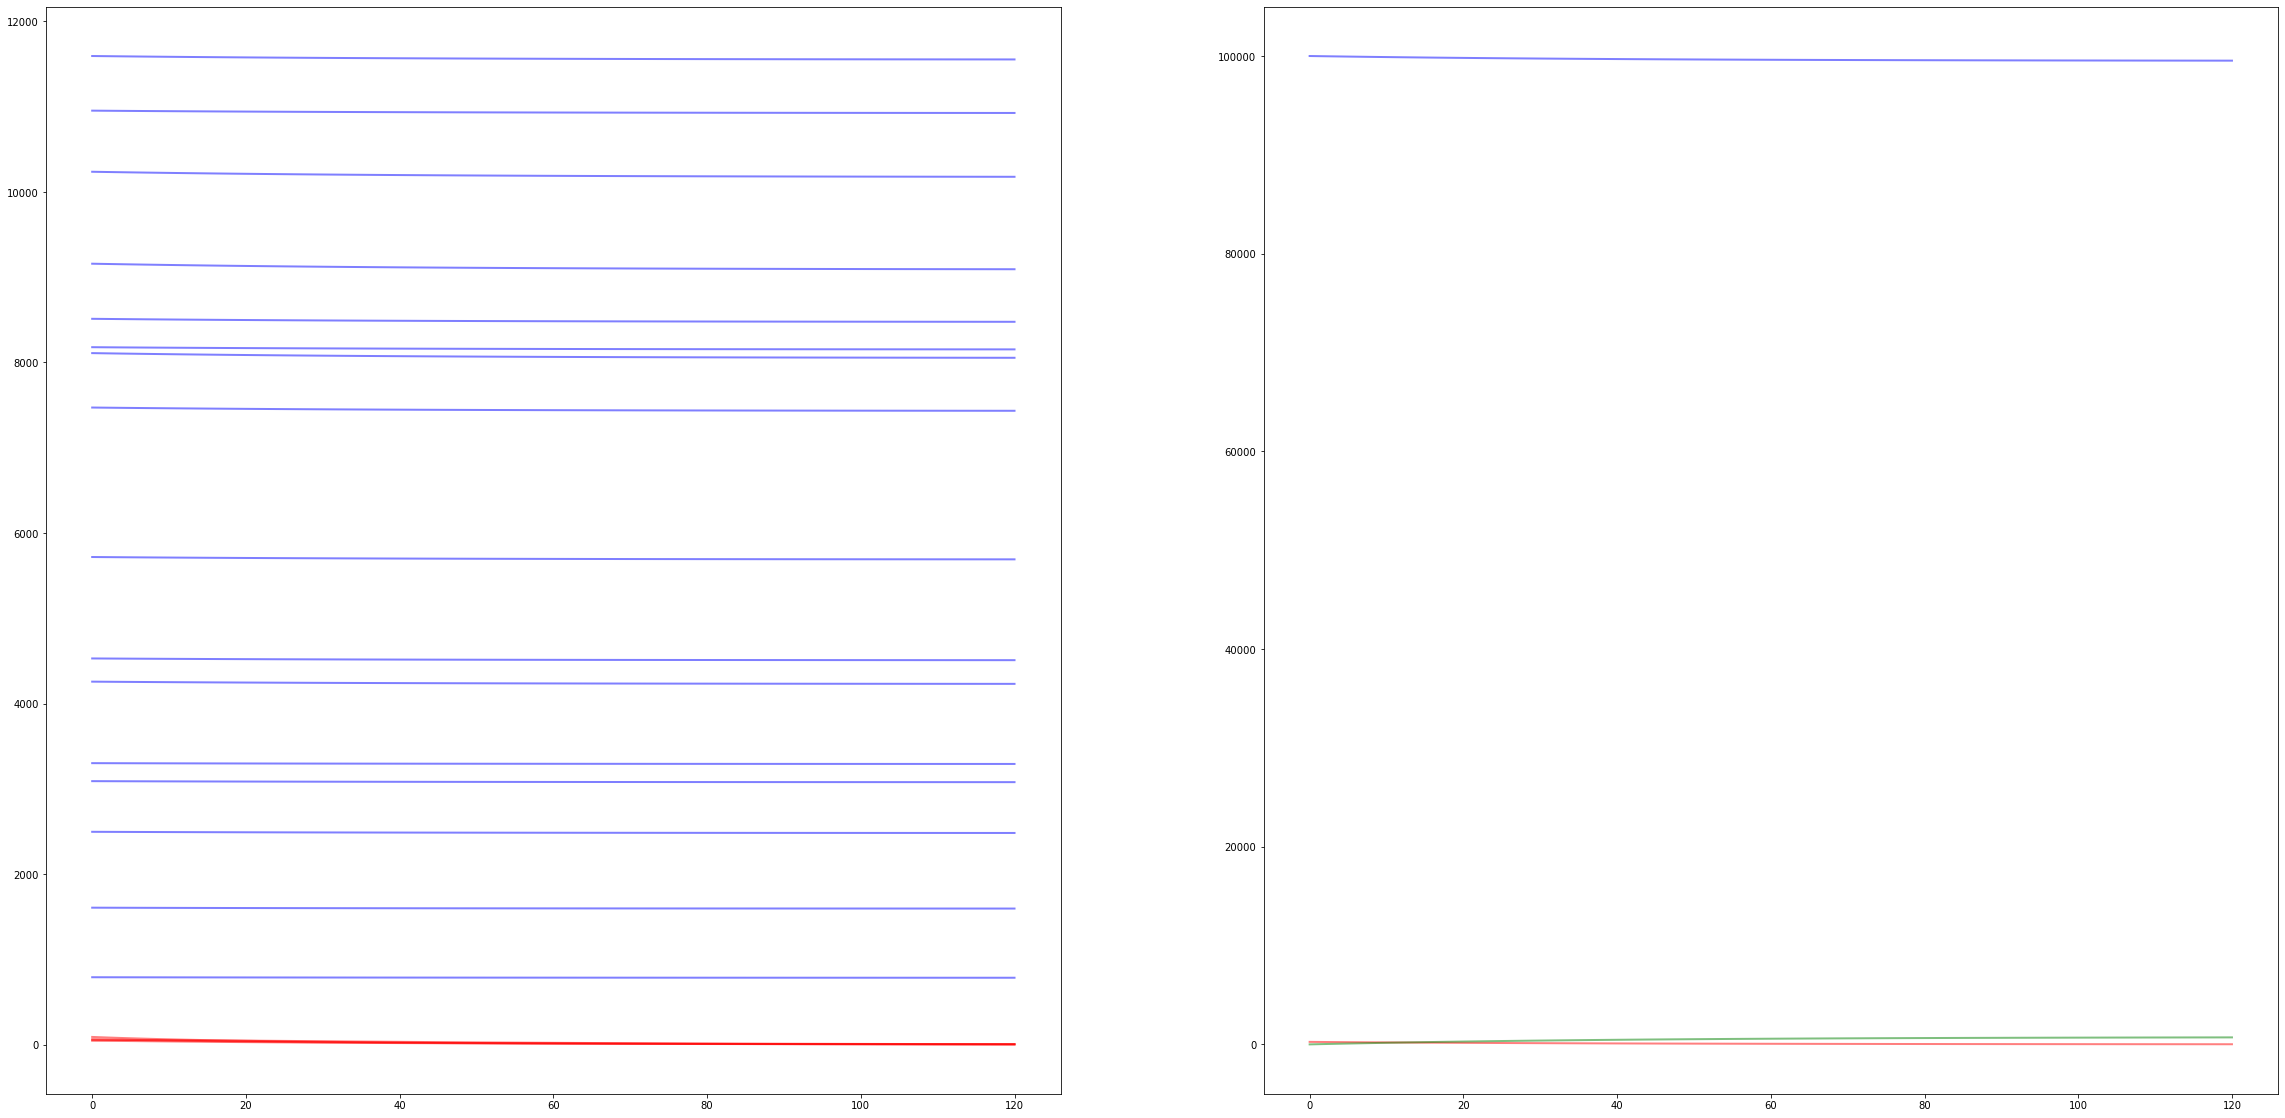

In [61]:
fig, ax = plt.subplots(1, 2, sharex = True, figsize = (40,20) )
# ax[0].set(xlabel = "t (Time in days)", ylabel = "Number",
#          title = "SIR Curve")
soln = solve_ivp(SIR, t, y0 = (S[0,0],S[0,1],S[0,2],S[0,3],
                               S[1,0],S[1,1],S[1,2],S[1,3],
                               S[2,0],S[2,1],S[2,2],S[2,3],
                               S[3,0],S[3,1],S[3,2],S[3,3],
                               I[0],I[1],I[2],I[3], I.sum(), R), 
                 dense_output = True, t_eval=np.arange(121),\
                 args = (L, N, beta/4, gamma) )
S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = soln.y

all_S = [S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33]
all_I = [I1,I2,I3,I4]

for Svc in all_S:
    ax[0].plot(soln.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')

for Ic in [I1,I2,I3,I4]:
    ax[0].plot(soln.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')

ax[1].plot(soln.t, np.sum(all_S, axis = 0), 'b', alpha=0.5, lw=2, label='Susceptible')
ax[1].plot(soln.t, np.sum(all_I, axis = 0),'r', alpha=0.5, lw=2, label='Infected')
ax[1].plot(soln.t, R0, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

In [59]:
v = 0
c = 0
for Svc in all_S:
    print(f"S: v = {v}, c = {c}: {Svc[-1]/Svc[0]}")
    if c == 3:
        v +=1
        c = 0
    c += 1

S: v = 0, c = 0: 0.9975255455045224
S: v = 0, c = 1: 0.997196081268766
S: v = 0, c = 2: 0.996866725867394
S: v = 0, c = 3: 0.9965374792644626
S: v = 1, c = 1: 0.996208341424039
S: v = 1, c = 2: 0.9958793123102025
S: v = 1, c = 3: 0.9955503918870441
S: v = 2, c = 1: 0.995221580118667
S: v = 2, c = 2: 0.9948928769691868
S: v = 2, c = 3: 0.994564282402729
S: v = 3, c = 1: 0.994235796383433
S: v = 3, c = 2: 0.9939074188754496
S: v = 3, c = 3: 0.99357914984294
S: v = 4, c = 1: 0.9932509892500797
S: v = 4, c = 2: 0.992922937061054
S: v = 4, c = 3: 0.9925949932400605


## Part 1b

In [2]:
bdata = np.load("part1b.npz")

In [3]:
bdata.files

['N', 'Lc', 'Ic_0', 'gamma', 'L_validation', 'L_test', 'betas_validation']

In [4]:
N_b = bdata['N'] # Each node has population N
L_b = bdata['Lc']
I_b = bdata['Ic_0']
gamma_b = bdata['gamma']
L_validation = bdata['L_validation']
L_test = bdata['L_test']
betas_validation = bdata['betas_validation']

In [5]:
def SIR_b(t, y, N, beta, gamma):
    
    Sv0, Sv1, Sv2, Sv3, I0, I1, I2, I3, I = y

    dSv0dt = -beta[0] * Sv0 * I / N
    dSv1dt = -beta[1] * Sv1 * I / N
    dSv2dt = -beta[2] * Sv2 * I / N
    dSv3dt = -beta[3] * Sv3 * I / N
    
    dI0dt = -1 * dSv0dt - (gamma * I0)
    dI1dt = -1 * dSv1dt - (gamma * I1)
    dI2dt = -1 * dSv2dt - (gamma * I2)
    dI3dt = -1 * dSv3dt - (gamma * I3)
    
    dIdt = np.sum([dI0dt, dI1dt, dI2dt, dI3dt])    
   
    return dSv0dt, dSv1dt, dSv2dt, dSv3dt,\
    dI0dt, dI1dt, dI2dt, dI3dt, \
    dIdt

1) Using these distributions, total population sizes and observations of viral load densities L for 20 consecutive days (day 0 through day 19) for the 20 leaf nodes that are given to you, estimate the 16 parameters βv,c using grid search and MMSE on the “validation” data. In other words try to minimize MSE between Lvalidation and Lestimated. Compare the βv,c you estimated with the ground truth given in the file. This step is to make sure your code and logic works correctly.


In [34]:
# Beta Grid Search

def beta_gridsearch(beta_grid):
    '''Select what beta values you want to search for thru beta_grid
    e.g. beta_grid = np.linspace(0,1,21)'''
    pmf = [0.5,0.3,0.1,0.1,0.4,0.3,0.2,0.1,0.3,0.3,0.2,0.2,0.1,0.2,0.3,0.4]
    beta_mmse=np.zeros((4,4))
    prev_beta_vc = np.zeros(4)
    
    # Create initial values in vulnerability group v for grid search
    for start, end, pmf_start, pmf_end, i in \
    zip(range(0,20,5), range(5,25,5), range(0,16,4), range(4,20,4), range(4)):
        mmse = np.inf
        pmf0c = np.array(pmf[pmf_start:pmf_end])
        Sv0, Sv1, Sv2, Sv3 = pmf0c * 50000 * 5
        I0,I1,I2,I3 = I_b[start:end].sum(axis = 0)
        I_five_nodes = np.sum([I0,I1,I2,I3])

        start_time = time()
        # Grid search for optimal values of beta 
        for (betav0, betav1, betav2, betav3) in product(beta_grid, beta_grid, beta_grid, beta_grid):
            
            # Boolean
            bigger_than_prev_beta = (betav0 >= prev_beta_vc[0]) and betav1 >=(prev_beta_vc[1])\
            and (betav2 >= prev_beta_vc[2]) and (betav3 >=prev_beta_vc[3])
            
            # Check if beta values are greater as vulnerability increases and comorbidity increases, ignore
            # ignore product of beta values if conditions not satisfied
            
            if (betav0 <= betav1 <= betav2 <= betav3) and bigger_than_prev_beta:
                # If beta values valid, solve ODE with 
                beta = [betav0, betav1, betav2, betav3]
                
                # Solve ODE
                soln_obj = solve_ivp(SIR_b, t_span = (0,19), \
                                     y0 = (Sv0, Sv1, Sv2, Sv3,
                                     I0,I1,I2,I3, I_five_nodes), \
                                     t_eval = np.arange(20), dense_output = True, \
                                     args = (N_b * 5, beta, gamma_b))
                # Assign solutions from solution object
                Sv0_y, Sv1_y, Sv2_y, Sv3_y, I0_y, I1_y, I2_y, I3_y, I_nodes = soln_obj.y
                # Calculate sample L and MSE
                L_sample = np.sum(np.array([I0_y * L_b[0], I1_y * L_b[1],I2_y * L_b[2],I3_y * L_b[3]]), axis = 0)
                mse = mean_squared_error(L_validation[start:end].sum(axis=0), L_sample) 

                # If mse is lower, store new value
                if mse < mmse:
                    mmse = mse
                    beta_mmse[i,:] = beta
#                     print(beta_mmse[i,:],mmse)
                    
        # Store beta mmse estimates of previous vulnerability group for checking           
        prev_beta_vc = beta_mmse[i,:]
        end_time = time()
        print(I0_y * L_b[0], I1_y * L_b[1],I2_y * L_b[2],I3_y * L_b[3])
        print(f"Run time: {end_time - start_time:.2f} seconds")
        print(f"Estimated values are beta={beta_mmse[i,:]}")
        print(f"MMSE = {mmse}\n")
    return beta_mmse

# Individually calculating L for each node

In [34]:
# Beta Grid Search

def beta_gridsearch(beta_grid, pmf, I_b, L, prev_beta_vc):
    '''Select what beta values you want to search for thru beta_grid for FIVE NODES
    e.g. beta_grid = np.linspace(0,1,21), pmf[0:4], I_b[0:5] for first five nodes'''
    beta_mmse= None 
    mmse = np.inf
    start_time = time()

    # Grid search for optimal values of beta 
    for (betav0, betav1, betav2, betav3) in product(beta_grid, beta_grid, beta_grid, beta_grid):

        # Check if beta values are greater as vulnerability increases and comorbidity increases, ignore
        # ignore product of beta values if conditions not satisfied
         
        # Boolean
        bigger_than_prev_beta = (betav0 >= prev_beta_vc[0]) and betav1 >=(prev_beta_vc[1])\
        and (betav2 >= prev_beta_vc[2]) and (betav3 >=prev_beta_vc[3])
        
        if (betav0 <= betav1 <= betav2 <= betav3) and bigger_than_prev_beta:
            # If beta values valid, solve ODE with 
            beta = [betav0, betav1, betav2, betav3]
            nodes = 5
            
            L_array = np.empty((5,20))
            for n in range(nodes):
                Sv0, Sv1, Sv2, Sv3 = pmf * 50000
                I0,I1,I2,I3 = I_b[n]
#                 print(I0, I1,I2,I3)
                I_five_nodes = np.sum([I0,I1,I2,I3])
#                 print(I_five_nodes)
                # Solve ODE
                soln_obj = solve_ivp(SIR_b, t_span = (0,19), \
                                     y0 = (Sv0, Sv1, Sv2, Sv3,
                                     I0,I1,I2,I3, I_five_nodes), \
                                     t_eval = np.arange(20), dense_output = True, \
                                     args = (50000, beta, gamma_b))
                # Assign solutions from solution object
                Sv0_y, Sv1_y, Sv2_y, Sv3_y, I0_y, I1_y, I2_y, I3_y, I_nodes = soln_obj.y
                # Calculate sample L and MSE
                L_array[n] = np.sum(np.array([I0_y * L_b[0], I1_y * L_b[1],I2_y * L_b[2],I3_y * L_b[3]]), axis = 0)
                
            mse = mean_squared_error(L_array.sum(axis=0), L.sum(axis = 0)) 
#             print(L_array.sum(axis=0), L.sum(axis = 0))
#             print(mse)

            # If mse is lower, store new value
            if mse < mmse:
                mmse = mse
                beta_mmse = beta

    # Store beta mmse estimates of previous vulnerability group for checking           
    end_time = time()
    print(f"Run time: {end_time - start_time:.2f} seconds")
    print(f"Estimated values are beta={beta_mmse}")
    print(f"MMSE = {mmse}\n")
    return beta_mmse

Vulnerability 1

In [35]:
pmf = np.array([0.5,0.3,0.1,0.1,0.4,0.3,0.2,0.1,0.3,0.3,0.2,0.2,0.1,0.2,0.3,0.4])
beta_mmse_1 = beta_gridsearch(np.linspace(0,1,21), pmf[0:4], I_b[0:5], L_validation[0:5], np.zeros(4))

Run time: 143.98 seconds
Estimated values are beta=[0.1, 0.15000000000000002, 0.2, 0.25]
MMSE = 119.82805138236475



Vulnerability 2

In [36]:
beta_mmse_2 = beta_gridsearch(np.linspace(0,1,21), pmf[4:8], I_b[5:10], L_validation[5:10], [0.1,0.15,0.2,0.25])

Run time: 115.32 seconds
Estimated values are beta=[0.2, 0.25, 0.30000000000000004, 0.4]
MMSE = 5442.61196567023



Vulnerability 3

In [37]:
beta_mmse_3 = beta_gridsearch(np.linspace(0,1,21), pmf[8:12], I_b[10:15], L_validation[10:15], [0.2,0.25,0.3,0.4])

Run time: 89.89 seconds
Estimated values are beta=[0.5, 0.5, 0.55, 0.6000000000000001]
MMSE = 18482529.661709692



Vulnerability 4

In [39]:
beta_mmse_2 = beta_gridsearch(np.linspace(0,1,21), pmf[12:16], I_b[15:20], L_validation[15:20], [0.35,0.45,0.5,0.6])

Run time: 47.87 seconds
Estimated values are beta=[0.5, 0.5, 0.5, 0.8500000000000001]
MMSE = 157360.80613208757



In [16]:
betas_validation

array([[0.1 , 0.15, 0.2 , 0.25],
       [0.2 , 0.25, 0.3 , 0.4 ],
       [0.35, 0.45, 0.5 , 0.6 ],
       [0.4 , 0.5 , 0.6 , 0.8 ]])

# Debugging

PMF of vulnerability 0: [0.4 0.3 0.2 0.1]

Sv0 = 100000.0, Sv1 = 75000.0, Sv2 = 50000.0, Sv3 = 25000.0

Infected population of first five nodes: Row = node, Column = comorbidity [[47 90 51 65]
 [82 31 64 86]
 [30 66 39 47]
 [59 26 77 38]
 [20 63 70 15]]

Infected population of first five nodes summed by comorbidity: (233, 202, 317, 194)

Searching through beta = [0.2, 0.25, 0.3, 0.4]

L_sample = [  566.6          663.89247048   781.68240821   923.84466231
  1094.94150009  1300.46659281  1546.87066177  1841.56147837
  2192.72944742  2609.69491815  3104.80343028  3691.28178498
  4382.99179549  5194.43028715  6140.72909739  7237.6550757
  8500.94012885  9944.99592112 11580.24534224 13411.95258423]

L_validation = [  571.44465698   697.87194942   880.42176266  1138.36848992
  1465.12860526  1928.65907658  2587.05065392  3522.97260821
  4718.48105516  6305.22683465  8438.05202668 11201.12617122
 14117.27886566 16838.84863735 20078.30998661 22411.08651489
 24625.62528207 26240.27862209 27431

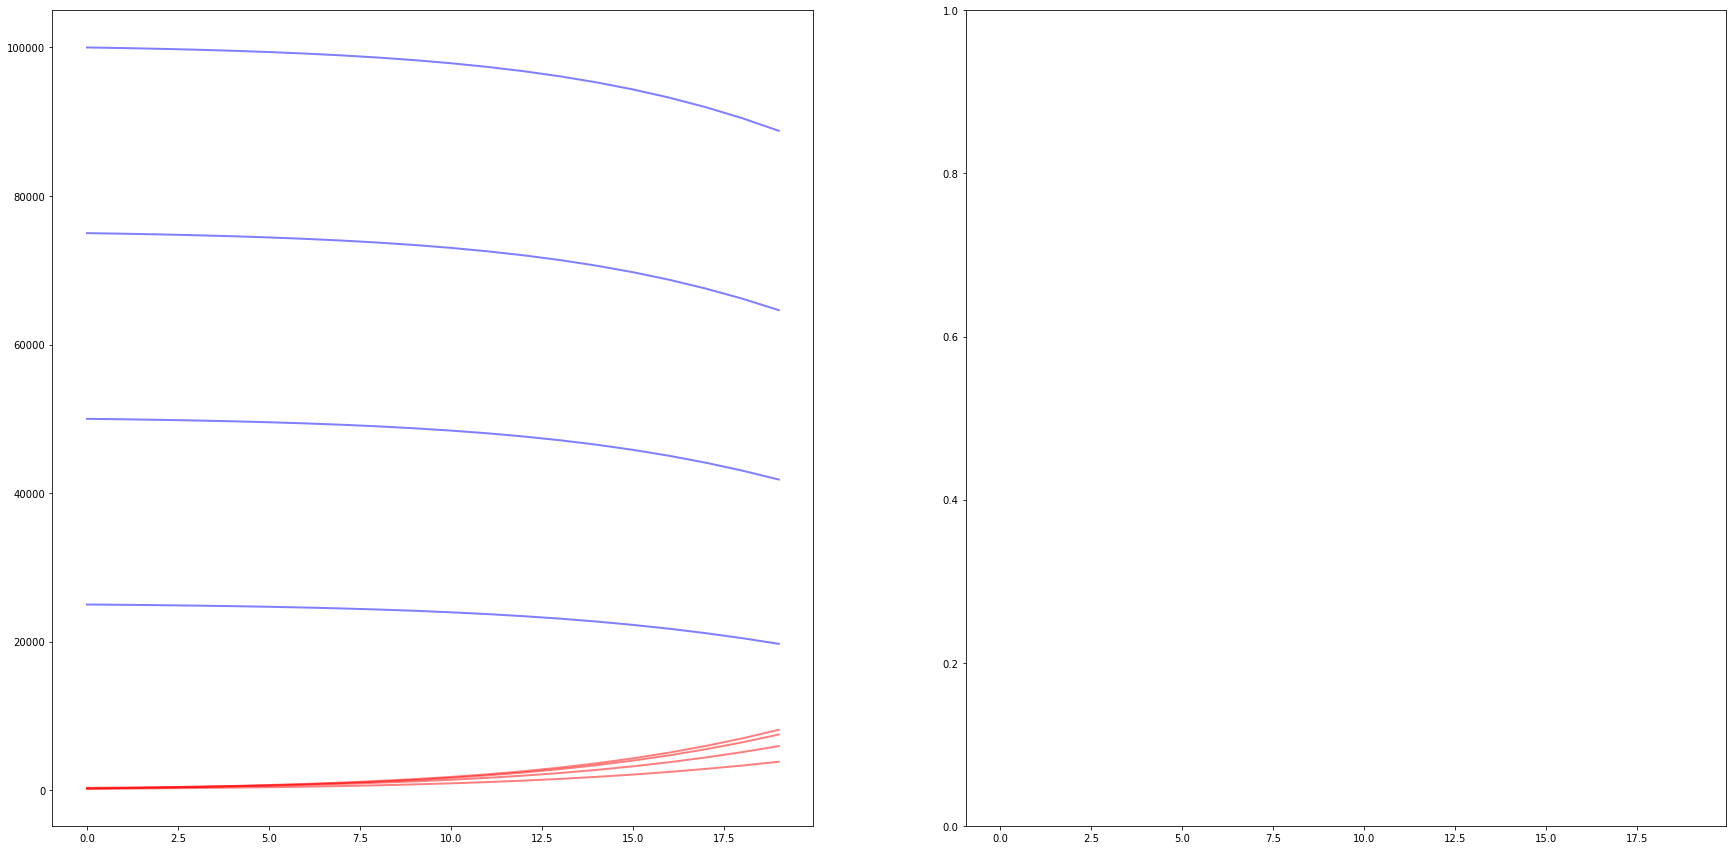

In [29]:
fig, ax = plt.subplots(1, 2, sharex = True, figsize = (30,15) )
mmse=np.inf
beta_mmse=np.nan
pmf = [0.5,0.3,0.1,0.1,0.4,0.3,0.2,0.1,0.3,0.3,0.2,0.2,0.1,0.2,0.3,0.4]
    
pmf0c = np.array(pmf[4:8])
print(f"PMF of vulnerability 0: {pmf0c}\n")
Sv0, Sv1, Sv2, Sv3 = pmf0c * 50000 * 5
print(f"Sv0 = {Sv0}, Sv1 = {Sv1}, Sv2 = {Sv2}, Sv3 = {Sv3}\n")
print(f"Infected population of first five nodes: Row = node, Column = comorbidity {I_b[0:5]}\n")
I0,I1,I2,I3 = I_b[6:11].sum(axis=0)
print(f"Infected population of first five nodes summed by comorbidity: {I0,I1,I2,I3}\n")
I_five_nodes = np.sum([I0,I1,I2,I3])

beta_grid=np.linspace(0,1,21)
beta_mmse = []
for (betav0, betav1, betav2, betav3) in product(beta_grid, beta_grid, beta_grid, beta_grid):
        
    if (betav0 <= betav1 <= betav2 <= betav3):
#         beta = [betav0, betav1, betav2, betav3]
        beta = [0.2 , 0.25, 0.3 , 0.4 ]

        soln_obj = solve_ivp(SIR_b, t_span = (0,19), \
                             y0 = (Sv0, Sv1, Sv2, Sv3,
                             I0,I1,I2,I3, I_five_nodes), \
                             t_eval = np.arange(20), dense_output = True, \
                             args = (N_b * 5, beta, gamma_b))

        Sv0_y, Sv1_y, Sv2_y, Sv3_y, I0_y, I1_y, I2_y, I3_y, I_nodes = soln_obj.y
        all_S = [Sv0_y, Sv1_y, Sv2_y, Sv3_y]
        for Svc in all_S:
            ax[0].plot(soln_obj.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')

        # Plot # Infected vc
        all_I = [I0_y, I1_y, I2_y, I3_y]
        for Ic in all_I:
            ax[0].plot(soln_obj.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')
#         print(I0_y)
#         print(I1_y)
#         print(I2_y)
#         print(I3_y)
        L_sample = np.sum(np.array([I0_y * L_b[0], I1_y * L_b[1],I2_y * L_b[2],I3_y * L_b[3]]), axis = 0)
        
        mse = mean_squared_error(np.sum(L_validation[6:11], axis = 0), L_sample) 
        
        # If mse is lower, store new value
        if mse < mmse:
            print(f"Searching through beta = {beta}\n")
            print(f"L_sample = {L_sample}\n")
            print(f"L_validation = {L_validation[6:11].sum(axis=0)}\n")
            print(f"MSE = {mse}")
            mmse = mse
            beta_mmse = []
    break

2) Now use the “test” data (20 L values for 20 days) from the file and estimate the βv,c. This time you won’t have access to the ground truth βv,c values. Print the βv,c values you estimated.

3) Use the βv,c you found to predict the disease behaviour for the future. Solve the equations for 100 days and plot S, I, R, L values for the first node in each social vulnerability case. On L graphs, also plot the corresponding observed values for the first 20 days (with a circle marker).
